# Data modelling

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import missingno
from scipy.stats import pearsonr
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, PredefinedSplit
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.metrics import (
    precision_score,
    recall_score,
    precision_recall_curve,
    f1_score,
    balanced_accuracy_score,
    average_precision_score
)

In [2]:
plt.style.use("fivethirtyeight")

In [3]:
SMALL_SIZE = 20
MEDIUM_SIZE = 22
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## 1 - Data acquisition

In [4]:
df_raw = pd.read_parquet("./data/sinasc_br_19_20.parquet")

## 2 - Data preparation

In [5]:
df_raw.replace({"nan":np.nan}, inplace=True)

In [6]:
categorical_variables = df_raw.select_dtypes("object").columns.tolist()

In [7]:
categorical_variables.remove("place_of_birth")
categorical_variables.remove("induced_labor")
categorical_variables.remove("childbirth")

In [8]:
df_modelling = (
    pd.get_dummies(
        (
            df_raw
            .drop(columns=["gestational_week", "geoses", "geoses_poverty", "geoses_education", "place_of_birth", "induced_labor", "childbirth"])
            .dropna()
            .query(
                "mom_age < 40"
                "& dad_age < 45"
                "& number_alive_children < 5"
                "& number_dead_children < 5"
            )
            .drop_duplicates()
            .reset_index(drop=True)
        ),
        columns=categorical_variables,
        drop_first=True
    )
    .sample(frac=0.4)
)

### 2.1 - Train-val-test split

In [9]:
df_train_val, df_test = train_test_split(df_modelling, test_size=0.2, stratify=df_modelling["premature"])

In [10]:
X_train_val_raw, y_train_val_raw = df_train_val.drop(columns=["premature"]), df_train_val["premature"]

In [11]:
X_test_raw, y_test_raw = df_test.drop(columns=["premature"]), df_test["premature"]

### 2.2 - Sampling

In [12]:
sampler = RandomUnderSampler(random_state=42)
X_res, y_res = sampler.fit_resample(X_train_val_raw, y_train_val_raw)

In [13]:
df_res = pd.concat([X_res, y_res], axis=1)

In [14]:
#df_res.to_parquet("./data_resampled.parquet", index=False)

### 2.3 - Scaling

In [15]:
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_res)
X_test_scaled = scaler.transform(X_test_raw)

## 3 - Model training

### 3.1 - Logistic regression

In [16]:
grid_search_logistic_regression = GridSearchCV(
    LogisticRegression(),
    param_grid={
        "C":np.logspace(-3, 0, 5),
        "max_iter":[1000],
        "random_state":[42]
    },
    scoring="accuracy",
    n_jobs=-1,
    return_train_score=True
).fit(X_train_scaled, y_res)

In [17]:
best_logistic_regression = grid_search_logistic_regression.best_estimator_

In [18]:
df_grid_search_logistic_regression = pd.DataFrame({
    "C":grid_search_logistic_regression.cv_results_["param_C"],
    "mean_train_score":grid_search_logistic_regression.cv_results_["mean_train_score"],
    "std_train_score":grid_search_logistic_regression.cv_results_["std_train_score"],
    "mean_test_score":grid_search_logistic_regression.cv_results_["mean_test_score"],
    "std_test_score":grid_search_logistic_regression.cv_results_["std_test_score"],
})

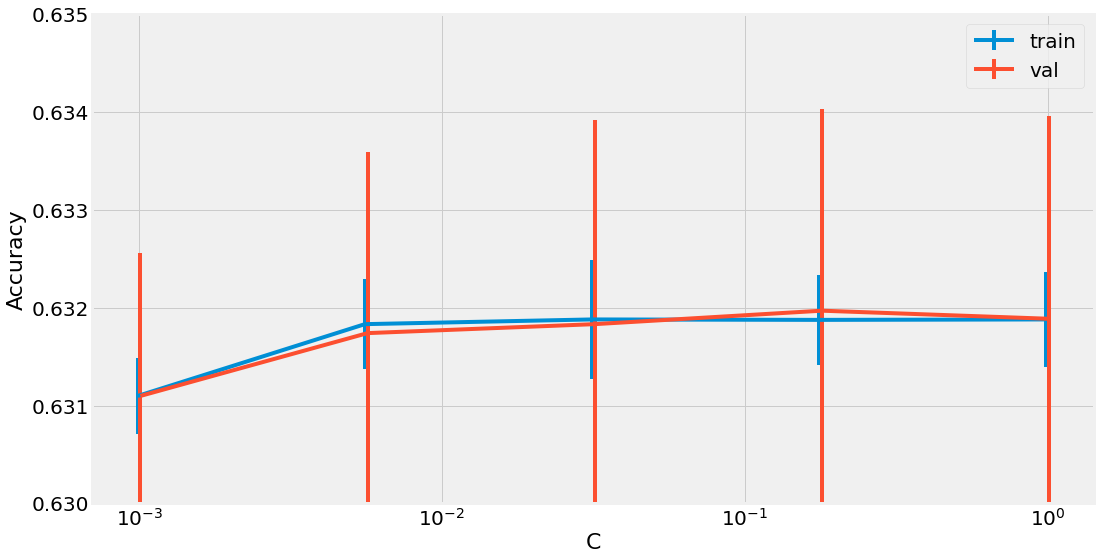

In [42]:
fig, ax = plt.subplots(figsize=(16,9))

ax.errorbar(
    x=df_grid_search_logistic_regression["C"]*0.99,
    y=df_grid_search_logistic_regression["mean_train_score"],
    yerr=df_grid_search_logistic_regression["std_train_score"],
    label="train"
    
)

ax.errorbar(
    x=df_grid_search_logistic_regression["C"]*1.01,
    y=df_grid_search_logistic_regression["mean_test_score"],
    yerr=df_grid_search_logistic_regression["std_test_score"],
    label="val"
)

ax.set_xlabel("C")
ax.set_ylabel("Accuracy")
ax.set_xscale("log")
ax.legend()
ax.set_ylim(0.630, 0.6350);

### 3.2 - Decision tree

In [20]:
grid_search_decision_tree = GridSearchCV(
    DecisionTreeClassifier(),
    param_grid={
        "max_depth":np.arange(1, 11, 1),
        "random_state":[42]
    },
    scoring="accuracy",
    n_jobs=-1,
    return_train_score=True
).fit(X_train_scaled, y_res)

In [21]:
best_decision_tree = grid_search_decision_tree.best_estimator_

In [22]:
df_grid_search_decision_tree = pd.DataFrame({
    "max_depth":grid_search_decision_tree.cv_results_["param_max_depth"],
    "mean_train_score":grid_search_decision_tree.cv_results_["mean_train_score"],
    "std_train_score":grid_search_decision_tree.cv_results_["std_train_score"],
    "mean_test_score":grid_search_decision_tree.cv_results_["mean_test_score"],
    "std_test_score":grid_search_decision_tree.cv_results_["std_test_score"],
})

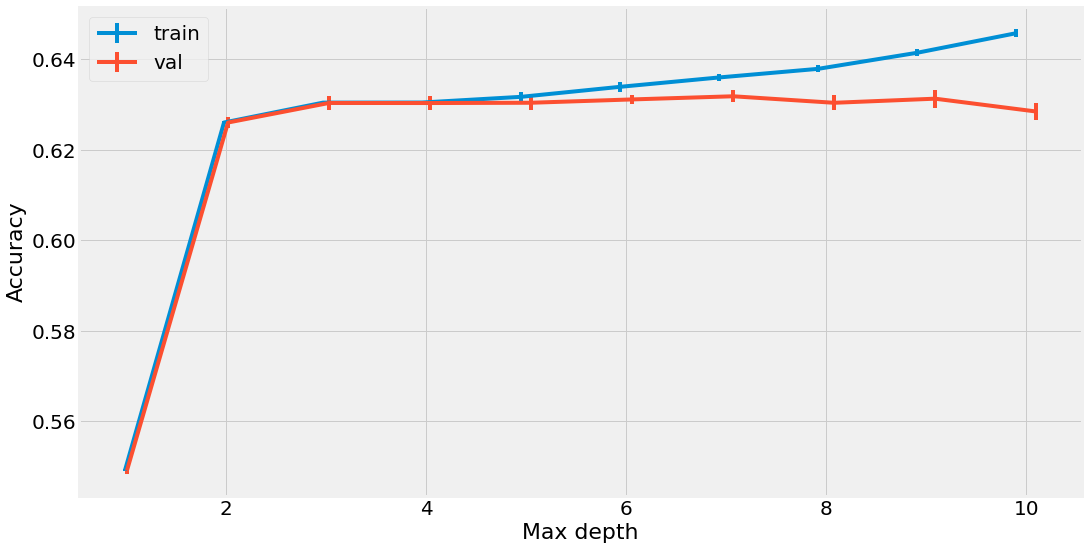

In [43]:
fig, ax = plt.subplots(figsize=(16,9))

ax.errorbar(
    x=df_grid_search_decision_tree["max_depth"]*0.99,
    y=df_grid_search_decision_tree["mean_train_score"],
    yerr=df_grid_search_decision_tree["std_train_score"],
    label="train"
    
)

ax.errorbar(
    x=df_grid_search_decision_tree["max_depth"]*1.01,
    y=df_grid_search_decision_tree["mean_test_score"],
    yerr=df_grid_search_decision_tree["std_test_score"],
    label="val"
)

ax.set_xlabel("Max depth")
ax.set_ylabel("Accuracy")
ax.legend();


### 3.3 - XGBoost

In [24]:
grid_search_xgboost = GridSearchCV(
    XGBClassifier(),
    param_grid={
        "n_estimators":np.arange(15, 25, 2),
        "max_depth":np.arange(5, 9, 1)
    },
    scoring="accuracy",
    return_train_score=True,
    cv=3,
    n_jobs=-1
).fit(X_train_scaled, y_res)

In [25]:
best_xgboost = grid_search_xgboost.best_estimator_

In [26]:
grid_search_xgboost.best_params_

{'max_depth': 6, 'n_estimators': 17}

In [27]:
df_grid_search_xgboost = pd.DataFrame({
    "n_estimators":{k: [dic[k] for dic in grid_search_xgboost.cv_results_["params"]] for k in grid_search_xgboost.cv_results_["params"][0]}["n_estimators"],
    "max_depth":{k: [dic[k] for dic in grid_search_xgboost.cv_results_["params"]] for k in grid_search_xgboost.cv_results_["params"][0]}["max_depth"],
    "mean_train_score":grid_search_xgboost.cv_results_["mean_train_score"],
    "std_train_score":grid_search_xgboost.cv_results_["std_train_score"],
    "mean_test_score":grid_search_xgboost.cv_results_["mean_test_score"],
    "std_test_score":grid_search_xgboost.cv_results_["std_test_score"],
})

In [28]:
max_depth_list = df_grid_search_xgboost["max_depth"].unique().tolist()
max_depth_list.sort()

In [29]:
df_grid_search_xgboost[["mean_test_score", "mean_train_score"]].describe()

,mean_test_score,mean_train_score
count,20.000000,20.000000
mean,0.635562,0.651714
std,0.000374,0.009027
min,0.634850,0.639501
25%,0.635382,0.643853
50%,0.635588,0.649780
75%,0.635804,0.658045
max,0.636226,0.669562


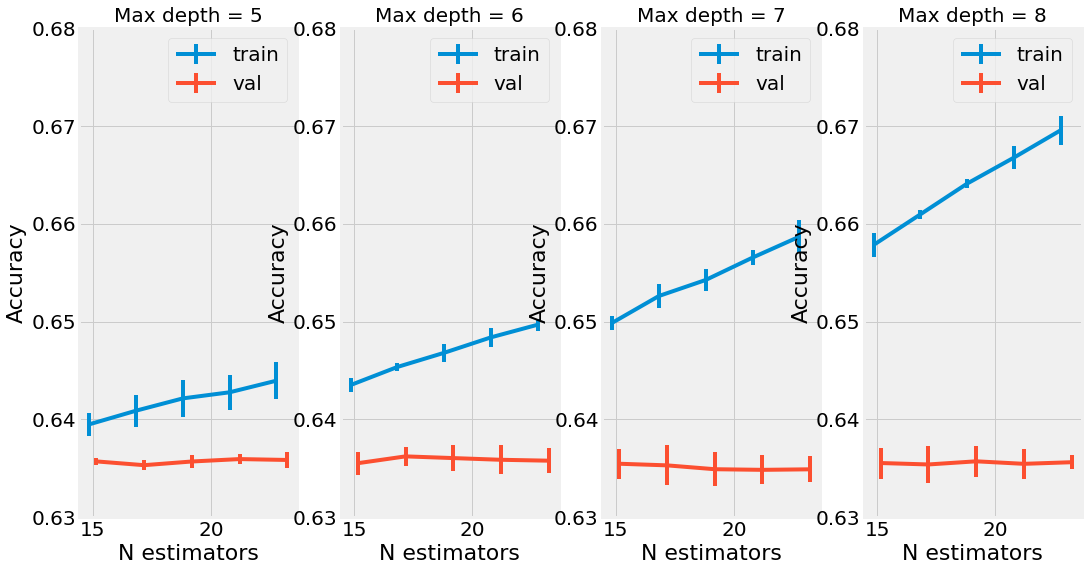

In [30]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(16,9))

for i, max_depth in enumerate(max_depth_list):
    df_selected = df_grid_search_xgboost.query(f"max_depth == {max_depth}")
    
    ax[i].errorbar(
        x=df_selected["n_estimators"]*0.99,
        y=df_selected["mean_train_score"],
        yerr=df_selected["std_train_score"],
        label="train"
        
    )

    ax[i].errorbar(
        x=df_selected["n_estimators"]*1.01,
        y=df_selected["mean_test_score"],
        yerr=df_selected["std_test_score"],
        label="val"
    )

    ax[i].set_xlabel("N estimators")
    ax[i].set_ylabel("Accuracy")
    ax[i].set_title(f"Max depth = {max_depth}")
    ax[i].set_ylim(0.63, 0.68)
    ax[i].legend()


## 4 - Model comparison

In [31]:
df_model_comparison = pd.DataFrame({
    "Model":["LogReg", "DecTree", "XGBoost"],
    "Acc":[grid_search_logistic_regression.best_score_, grid_search_decision_tree.best_score_, grid_search_xgboost.best_score_]
})

In [32]:
df_model_comparison

,Model,Acc
0,LogReg,0.631970
1,DecTree,0.631841
2,XGBoost,0.636226


(0.0, 100.0)

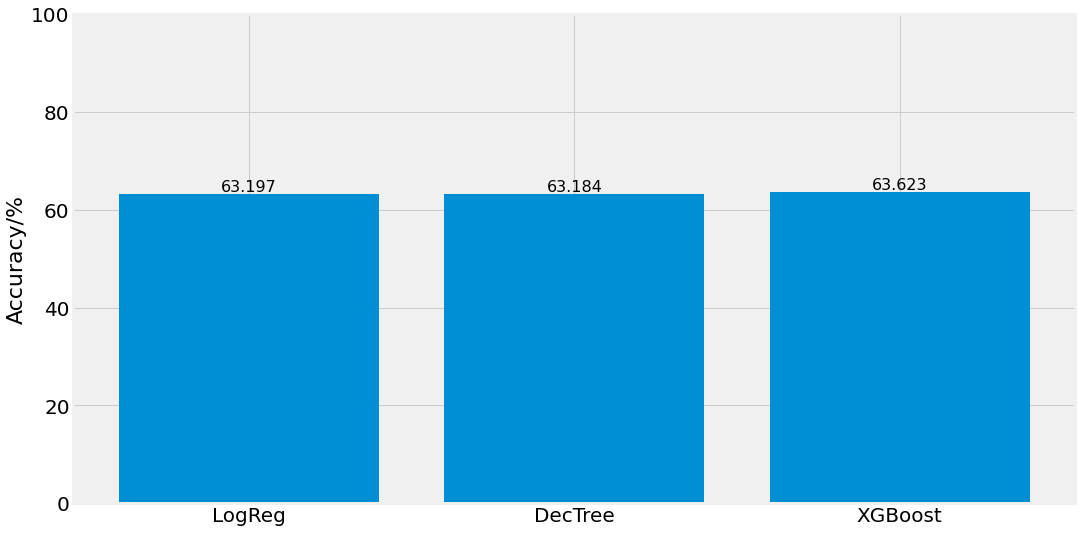

In [33]:
fig, ax = plt.subplots(figsize=(16, 9))

bar = ax.bar(
    df_model_comparison.index,
    100*df_model_comparison["Acc"]
)

ax.bar_label(bar, fmt='%.3f', fontsize=16)

ax.set_xticks(df_model_comparison.index)
ax.set_xticklabels(df_model_comparison["Model"])
ax.set_ylabel("Accuracy/%")
ax.set_ylim(0, 100)

## 5 - Model performance

In [34]:
y_test_pred_proba = best_xgboost.predict_proba(X_test_scaled)[:, 1]
y_test_pred = best_xgboost.predict(X_test_scaled)

In [35]:
df_metrics = pd.DataFrame({
    "metric":["Precision", "Recall", "F1", "BalAcc"],
    "result":[
        precision_score(y_test_raw, y_test_pred),
        recall_score(y_test_raw, y_test_pred),
        f1_score(y_test_raw, y_test_pred),
        balanced_accuracy_score(y_test_raw, y_test_pred)
    ]
})

In [36]:
df_metrics

,metric,result
0,Precision,0.211969
1,Recall,0.500661
2,F1,0.297839
3,BalAcc,0.634186


In [37]:
precision, recall, threshold = precision_recall_curve(y_test_raw, y_test_pred_proba)

In [38]:
average_precision = average_precision_score(y_test_raw, y_test_pred_proba)

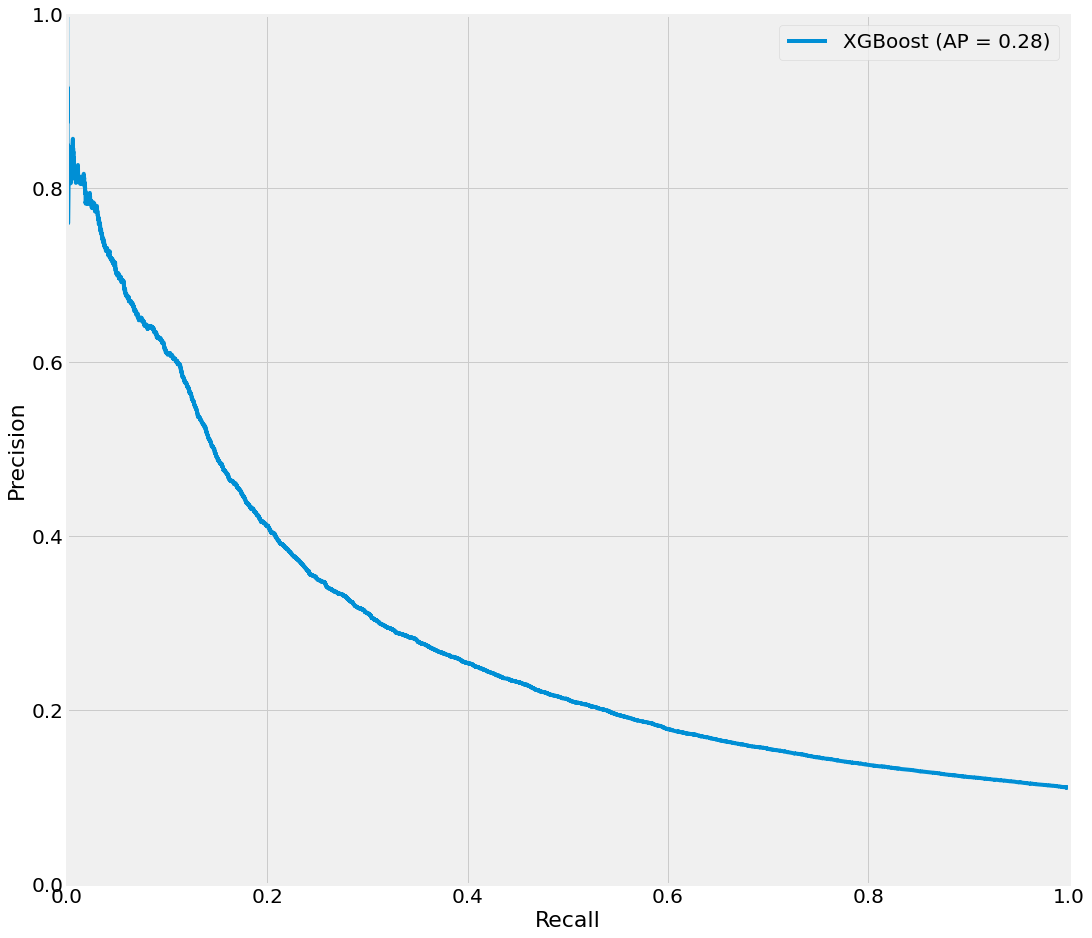

In [39]:
fig, ax = plt.subplots(figsize=(16,16))

ax.plot(
    recall,
    precision,
    label=f"XGBoost (AP = {np.round(average_precision, 2)})"
)
ax.legend()
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_xlabel("Recall")
ax.set_ylabel("Precision");

## 6 - Feature importance

In [40]:
df_importance = pd.DataFrame({
    "variable":X_res.columns.tolist(),
    "importance":best_xgboost.feature_importances_
}).sort_values("importance", ascending=False).reset_index(drop=True)

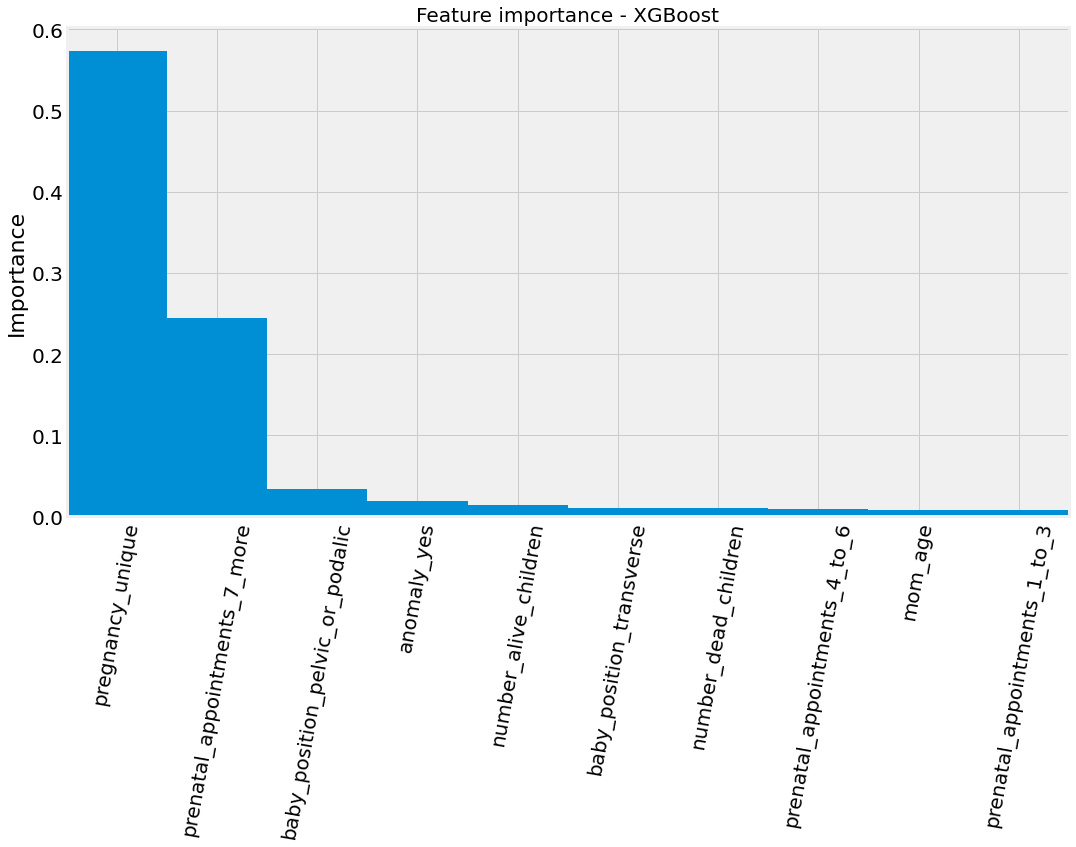

In [41]:
fig, ax = plt.subplots(figsize=(16,9))

top = 10

df_top = df_importance.iloc[0:top]

ax.bar(
    df_top.index,
    df_top["importance"],
    width=1    
)

ax.set_xticks(df_top.index)
ax.set_xticklabels(df_top["variable"], rotation=80)
ax.set_ylabel("Importance")
ax.set_title("Feature importance - XGBoost")
ax.set_xlim(-0.5, 9.5);